# Prediction
After the exploratory data analysis, a prediction will be made.
The folowing steps for this prediction:
1. Preprocessing - Handle missing data, Feature engineering.
2. Predictions - predicting with validation data and then with test data, metrics.
## 📚

In [70]:
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer

#pipeline tools
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from pipelinehelper import PipelineHelper
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

## Baseline 1: Basic approach

### Decisions:
* **Preprocessing:**
    1. **Missing data:** **Categoric** - fill with most frequent. **Discrete** - fill with most frequent. **Continuous** - fill with median.               
    2. **Feature Engineering**: only categoric labels, one hot encoding.
* **model training** - using cross validation in validation data on a simple decition tree model.
* **model testing** - train on whole train + validation set and use test data for results.

In [71]:
# Preprocessing for continuous data
contiuous_transformer = SimpleImputer(strategy='median')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
('imputer', SimpleImputer(strategy='most_frequent')),
('oh', OneHotEncoder())
])

# Preprocessing for discrete data
disc_transformer =  SimpleImputer(strategy='median')    

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', contiuous_transformer, Continuous+["LOAN"]),
        ('cat', categorical_transformer, Cats),
        ('disc', disc_transformer, Discrete)
    ])

In [72]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()

In [73]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
# Bundle preprocessing and modeling code in a pipeline
Baseline1 = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Preprocessing of training data, fit model 
Baseline1.fit(X_train2, y_train2)

# Preprocessing of validation data, get predictions
preds = Baseline1.predict(X_val)

# Evaluate the model
score = accuracy_score(y_val, preds)
auc = roc_auc_score(y_val, preds)
print('accuracy score:', score)
print("roc auc score: ",auc)

accuracy score: 0.8540268456375839
roc auc score:  0.765219660722053


In [74]:
from sklearn.model_selection import cross_val_score
CV = cross_val_score(Baseline1, X_train, y_train, cv=5)
print(f"validation accuracy on 5 fold cross validation: {CV}")
print(f"validation mean accuracy: {CV.mean()}")

validation accuracy on 5 fold cross validation: [0.88050314 0.85220126 0.86373166 0.88247639 0.86988458]
validation mean accuracy: 0.8697594048145435


In [75]:
Baseline1.fit(X_train, y_train)
preds = Baseline1.predict(X_test)
score = accuracy_score(y_test, preds)
auc = roc_auc_score(y_test, preds)
print('test accuracy score:', score)
print("test roc auc score: ",auc)

test accuracy score: 0.8817114093959731
test roc auc score:  0.7958683651804671


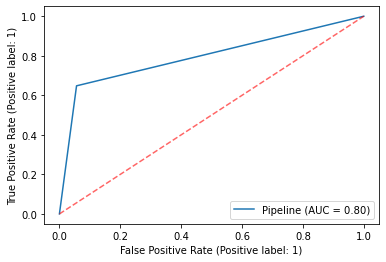

In [76]:
from sklearn.metrics import plot_roc_curve
import matplotlib.pyplot as plt
plot_roc_curve(Baseline1,X_test, y_test)
plt.plot([0, 1], [0, 1], linestyle='--', color='r', alpha=.6)         
plt.show()

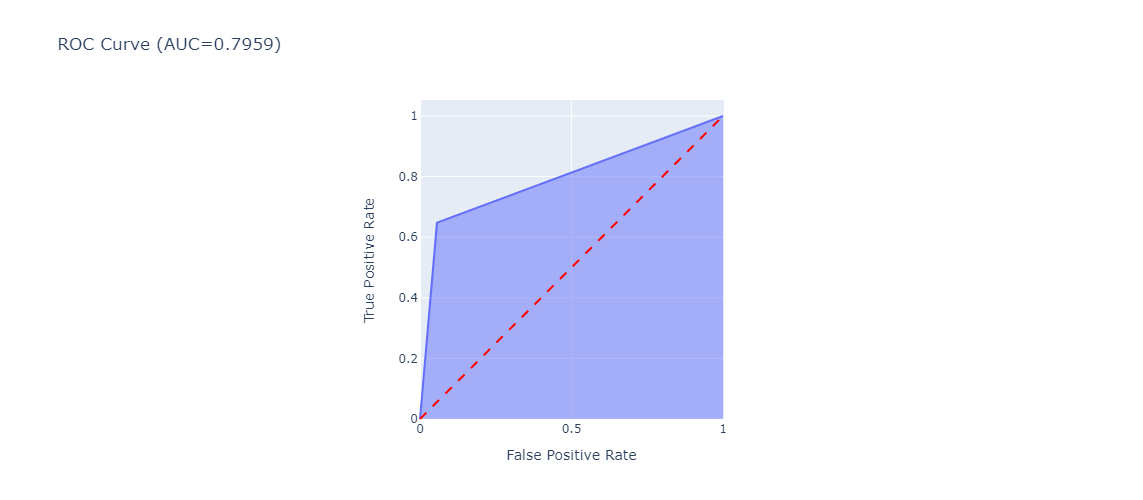

In [77]:
import plotly.express as px
from sklearn.metrics import roc_curve, auc
y_score = Baseline1.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score)
fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(color="red",dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

In [78]:
from sklearn.metrics import classification_report
print(pd.crosstab(y_test, preds, rownames=["Actual"], colnames=["Predicted"]))
print(f"\n{classification_report(y_test, preds)}")

Predicted    0    1
Actual             
0          889   53
1           88  162

              precision    recall  f1-score   support

           0       0.91      0.94      0.93       942
           1       0.75      0.65      0.70       250

    accuracy                           0.88      1192
   macro avg       0.83      0.80      0.81      1192
weighted avg       0.88      0.88      0.88      1192



In [79]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, preds)

array([[889,  53],
       [ 88, 162]], dtype=int64)